In [ ]:
!pip install optuna

In [ ]:
!pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.5 MB/s eta 0:00:00


In [ ]:
!pip install imblearn

In [ ]:
!unzip /content/hcv+data.zip -d /content/hcv+data


Archive:  /content/hcv+data.zip
 extracting: /content/hcv+data/hcvdat0.csv  


In [ ]:
#Imports needed libraries
import numpy as np #linear algebra
import pandas as pd #data manipulation
import matplotlib.pyplot as plt #data viz
from matplotlib.gridspec import GridSpec #data viz
from matplotlib.animation import FuncAnimation #animation
import seaborn as sns #data viz
#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA #principle component analysis
from IPython.display import HTML #display gif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #balance classes
import optuna
#models to try out
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import graphviz #graph of model
#metrics
from sklearn import metrics
#shap
import shap
import warnings #warnings
warnings.filterwarnings('ignore') #Hides warning popups

In [ ]:
#Reads in dataset
data = pd.read_csv('/content/hcv+data/hcvdat0.csv', index_col=0)
data.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


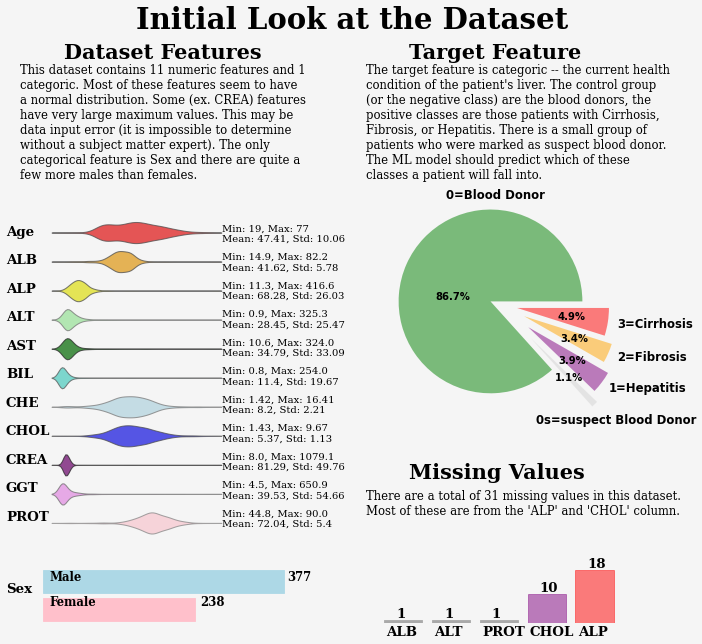

In [ ]:
#Visualizes Basic Data Statistics
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=16, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')

ax1_1 = fig.add_subplot(gs[1:2, 1:4]) #top left
ax1_2 = fig.add_subplot(gs[2:3, 1:4])
ax1_3 = fig.add_subplot(gs[3:4, 1:4])
ax1_4 = fig.add_subplot(gs[4:5, 1:4])
ax1_5 = fig.add_subplot(gs[5:6, 1:4])
ax1_6 = fig.add_subplot(gs[6:7, 1:4])
ax1_7 = fig.add_subplot(gs[7:8, 1:4])
ax1_8 = fig.add_subplot(gs[8:9, 1:4])
ax1_9 = fig.add_subplot(gs[9:10, 1:4])
ax1_10 = fig.add_subplot(gs[10:11, 1:4])
ax1_11 = fig.add_subplot(gs[11:12, 1:4])



ax2 = fig.add_subplot(gs[13:15, 1:5]) #bottom left
ax3 = fig.add_subplot(gs[:8, 6:]) #top right
ax4 = fig.add_subplot(gs[13:15, 6:]) #bottom right

# axes list
axes = [ ax1_1, ax1_2, ax1_3, ax1_4, ax1_5, ax1_6,
        ax1_7, ax1_8, ax1_9, ax1_10, ax1_11, ax2, ax3, ax4]


# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)


#------------------------------------------------------------
#Plots violin charts of numeric columns in top left
top_left_axes = [ax1_1, ax1_2, ax1_3, ax1_4, ax1_5, ax1_6,
        ax1_7, ax1_8, ax1_9, ax1_10, ax1_11]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'turquoise', 'lightblue',
          'blue', 'purple', 'violet', 'pink']
y = 0.805
for ax, color, column in zip(top_left_axes, colors, list(data.describe().columns)):
    sns.violinplot(x=column, y=None, data=data, ax=ax, inner=None, color=color)
    ax.collections[::2][0].set_alpha(0.75)
    fig.text(0.07, y, column,
            {'font':'Serif', 'weight':'bold','color': 'black', 'size':16})
    stats_text = "Min: {}, Max: {}\nMean: {}, Std: {}".format(round(data[column].min(), 2),
                                                              round(data[column].max(), 2),
                                                              round(data[column].mean(), 2),
                                                              round(data[column].std(), 2))
    fig.text(0.22, y-0.01, stats_text,
            {'font':'Serif', 'weight':'normal','color': 'black', 'size':12})
    y-=0.0475
#ax1 title
fig.text(0.11, 1.1, 'Dataset Features', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
fig.text(0.08, 0.9, "This dataset contains 11 numeric features and 1\ncategoric." +\
         " Most of these features seem to have\na normal distribution. " +\
         "Some (ex. CREA) features\nhave very large maximum values. " +\
         "This may be\ndata input error (it is impossible to determine\nwithout a subject matter expert). " +\
         "The only\ncategorical feature is Sex and there are quite a\nfew more males than females.",
        {'font':'Serif', 'weight':'normal','color': 'black', 'size':14})


#------------------------------------------------------------
#plots sex in bottom left
sex_data = data.groupby('Sex').Sex.count()
ax2_plot = ax2.barh(sex_data.index, sex_data.values)
for i, rect in enumerate(ax2_plot):
    if i == 0:
        rect.set_color('pink')
    else:
        rect.set_color('lightblue')


fig.text(0.07, 0.21, 'Sex', {'font':'Serif', 'weight':'bold','color': 'black', 'size':16})
fig.text(0.1, 0.23, 'Male', {'font':'Serif', 'weight':'bold','color': 'black', 'size':14})
fig.text(0.1, 0.1875, 'Female', {'font':'Serif', 'weight':'bold','color': 'black', 'size':14})
fig.text(0.265, 0.23, sex_data['m'], {'font':'Serif', 'weight':'bold','color': 'black', 'size':14})
fig.text(0.205, 0.1875, sex_data['f'], {'font':'Serif', 'weight':'bold','color': 'black', 'size':14})


#------------------------------------------------------------
#plots split of target feature in pie chart
ax3_plot = ax3.pie(data.groupby('Category').Category.count().values,
                   labels=data.groupby('Category').Category.count().index,
                    autopct='%1.1f%%', explode=[0.1, 0.5, 0.4, 0.3, 0.2],
                   colors=['green', 'lightgrey', 'purple', 'orange', 'red'])

for piece in ax3_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax3_plot[1]):
    text.set_weight('bold')
    text.set_size(14)
    if i == 0:
        text.set_y(1.2)
        text.set_x(0.5)
    if i == 1:
        text.set_y(-1.25)
        text.set_x(0.4)
for i, text in enumerate(ax3_plot[2]):
    text.set_weight('bold')
    text.set_size(12)
    if i == 0:
        text.set_y(0.1)
        text.set_x(-0.5)

fig.text(0.35, 1.1, 'Target Feature',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
fig.text(0.32, 0.9,
        "The target feature is categoric -- the current health\ncondition of the patient's liver. " +\
         "The control group\n(or the negative class) are the blood donors, the\npositive classes " +\
         "are those patients with Cirrhosis,\nFibrosis, or Hepatitis. There is a small group of " +\
         "\npatients who were marked as suspect blood donor.\nThe ML model should predict which of these\n" +\
         "classes a patient will fall into.",
        {'font':'Serif', 'weight':'normal','color': 'black', 'size':14})



#------------------------------------------------------------
#plot null values in barchart
null_data = data.isnull().sum()[data.isnull().sum() > 0].sort_values()
ax4_plot = ax4.bar(null_data.index, null_data.values)
for i, rect in enumerate(ax4_plot):
    height = rect.get_height()
    ax4.text((rect.get_x() + (rect.get_width() / 2.)) - 0.35, -4, null_data.index[i],
           {'font':'Serif', 'weight':'bold','color': 'black', 'size':16})
    ax4.text((rect.get_x() + (rect.get_width() / 2.)) - 0.15, 1. + height, null_data.values[i],
           {'font':'Serif', 'weight':'bold','color': 'black', 'size':16})
    if i < 3:
        rect.set_color('darkgrey')
    elif i == 3:
        rect.set_color('purple')
        rect.set_alpha(0.5)
    else:
        rect.set_color('red')
        rect.set_alpha(0.5)
fig.text(0.35, 0.4, 'Missing Values', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
fig.text(0.32, 0.34,
        "There are a total of 31 missing values in this dataset.\n" +\
         "Most of these are from the 'ALP' and 'CHOL' column.",
        {'font':'Serif', 'weight':'normal','color': 'black', 'size':14})

#-----------------------------------------------------------------
fig.text(0.16,1.15,'Initial Look at the Dataset', {'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
plt.show()

In [ ]:
#maps target feature
target_map = {'0=Blood Donor': 'Healthy',
             '0s=suspect Blood Donor': 'Healthy', #suspects are binned with blood donors for simplicity
             '1=Hepatitis': 'Hepatitis',
             '2=Fibrosis': 'Fibrosis',
             '3=Cirrhosis': 'Cirrhosis'}

data['Category'] = data.Category.map(target_map)

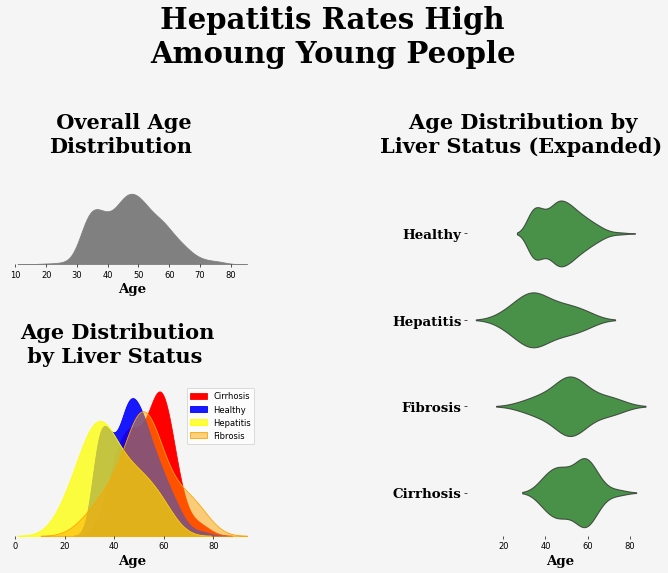

In [ ]:
#plots univariate analysis of age
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
#-------Ax 1------------------------------------------------
sns.kdeplot(x='Age', data=data, ax=ax1, shade=True, color='grey', alpha=1)
ax1.set_xlabel('Age', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='Age', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red', alpha=1, label='Cirrhosis')
sns.kdeplot(x='Age', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='blue', alpha=0.9, label='Healthy')
sns.kdeplot(x='Age', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='yellow', alpha=0.75, label='Hepatitis')
sns.kdeplot(x='Age', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange', alpha=0.5, label='Fibrosis')

ax2.legend()
ax2.set_xlabel('Age', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Remove the aspect argument
ax3_plot = sns.violinplot(x='Age', y='Category', data=data,  ax=ax3, inner=None)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Age', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#----------------------------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, " Overall Age\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "Age Distribution\n by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "    Age Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})

fig.text(0.15, 0.9, " Hepatitis Rates High\nAmoung Young People",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

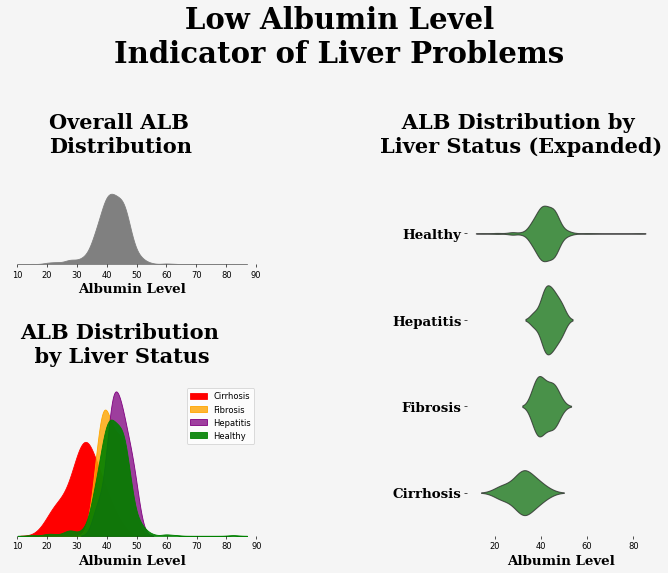

In [ ]:
#plots univariate analysis of ALB
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='ALB', data=data, ax=ax1, shade=True, color='grey', alpha=1)
ax1.set_xlabel('Albumin Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

sns.kdeplot(x='ALB', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red', alpha=1, label='Cirrhosis')
sns.kdeplot(x='ALB', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange', alpha=0.8, label='Fibrosis')
sns.kdeplot(x='ALB', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple', alpha=0.75, label='Hepatitis')
sns.kdeplot(x='ALB', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green', alpha=0.9, label='Healthy')


ax2.legend()
ax2.set_xlabel('Albumin Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Removed the aspect argument. If you want to control the aspect ratio of the violinplot,
# you can adjust the figsize of the overall figure or use ax.set_aspect() on the axes object.
ax3_plot = sns.violinplot(x='ALB', y='Category', data=data,  ax=ax3, inner=None)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Albumin Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#-------------------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall ALB\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "ALB Distribution\n  by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "   ALB Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})

fig.text(0.125, 0.9, "       Low Albumin Level\nIndicator of Liver Problems",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

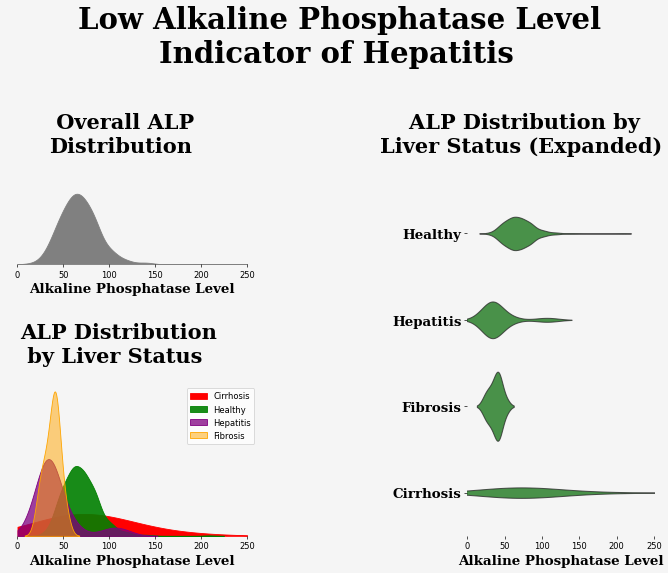

In [ ]:
#plots univariate analysis of ALP
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x=data['ALP'], ax=ax1, shade=True, color='grey', alpha=1, clip=[0, 250])
ax1.set_xlabel('Alkaline Phosphatase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='ALP', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0, 250])
sns.kdeplot(x='ALP', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0, 250])
sns.kdeplot(x='ALP', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0, 250])
sns.kdeplot(x='ALP', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0, 250])

ax2.legend()
ax2.set_xlabel('Alkaline Phosphatase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Removed the aspect argument. If you want to control the aspect ratio of the violinplot,
# you can adjust the figsize of the overall figure or use ax.set_aspect() on the axes object.
ax3_plot = sns.violinplot(x='ALP', y='Category', data=data,  ax=ax3, inner=None) #Removed aspect=2
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.set_xlim(0, 250)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Alkaline Phosphatase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#----------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, " Overall ALP\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "ALP Distribution\n by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "    ALP Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})

fig.text(0.1, 0.9, "Low Alkaline Phosphatase Level\n        Indicator of Hepatitis",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

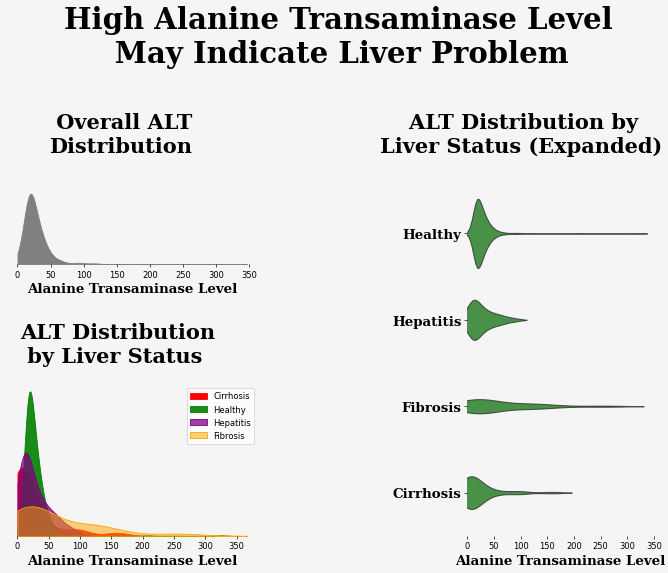

In [ ]:
#plots univariate analysis of ALT
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x=data['ALT'], ax=ax1, shade=True, color='grey', alpha=1, clip=[0,500])
#                                      ^ Changed 'ALT' to data['ALT']
ax1.set_xlabel('Alanine Transaminase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='ALT', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,500])
sns.kdeplot(x='ALT', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,500])
sns.kdeplot(x='ALT', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,500])
sns.kdeplot(x='ALT', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,500])

ax2.legend()
ax2.set_xlabel('Alanine Transaminase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Removed the aspect argument. If you want to control the aspect ratio, adjust figsize
ax3_plot = sns.violinplot(x='ALT', y='Category', data=data,  ax=ax3, inner=None)
ax3.set_xlim(0,350)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Alanine Transaminase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, " Overall ALT\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "ALT Distribution\n by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "    ALT Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})

fig.text(0.09, 0.9, "High Alanine Transaminase Level\n     May Indicate Liver Problem",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

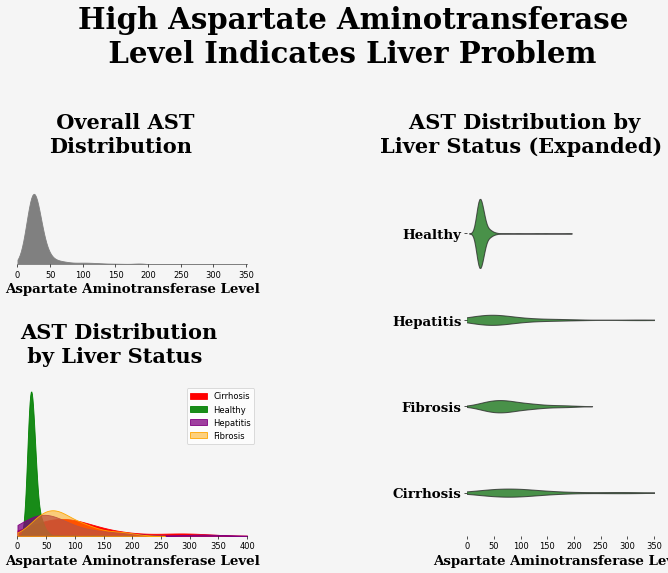

In [ ]:
#plots univariate analysis of AST
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='AST', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,400])
ax1.set_xlabel('Aspartate Aminotransferase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='AST', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,400])
sns.kdeplot(x='AST', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,400])
sns.kdeplot(x='AST', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,400])
sns.kdeplot(x='AST', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,400])

ax2.legend()
ax2.set_xlabel('Aspartate Aminotransferase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Removed the aspect argument. If you want to control the aspect ratio, adjust figsize
ax3_plot = sns.violinplot(x='AST', y='Category', data=data,  ax=ax3, inner=None) #Removed aspect=2
ax3.set_xlim(0,350)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Aspartate Aminotransferase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, " Overall AST\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "AST Distribution\n by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "    AST Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})


fig.text(0.1, 0.9, "High Aspartate Aminotransferase\n   Level Indicates Liver Problem",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title


plt.show()

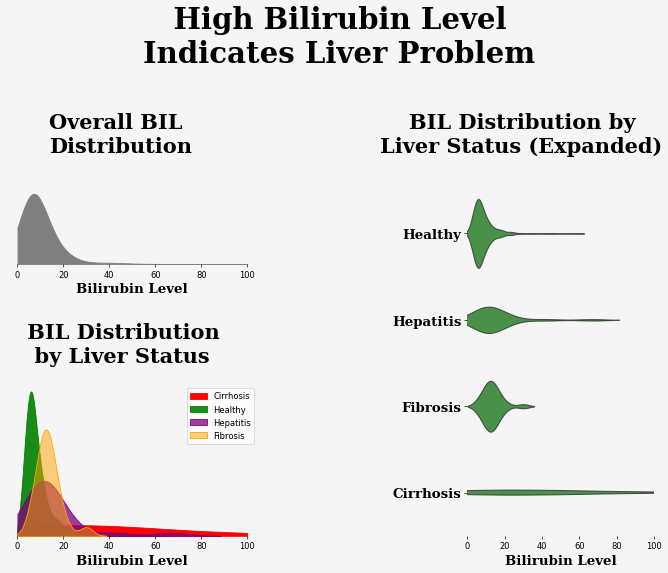

In [ ]:
#plots univariate analysis of BIL
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='BIL', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,100])
ax1.set_xlabel('Bilirubin Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='BIL', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,100])
sns.kdeplot(x='BIL', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,100])
sns.kdeplot(x='BIL', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,100])
sns.kdeplot(x='BIL', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,100])

ax2.legend()
ax2.set_xlabel('Bilirubin Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Removed the aspect argument. If you want to control the aspect ratio, adjust figsize
ax3_plot = sns.violinplot(x='BIL', y='Category', data=data,  ax=ax3, inner=None) #Removed aspect=2
ax3.set_xlim(0,100)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Bilirubin Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall BIL\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, " BIL Distribution\n  by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "    BIL Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})

fig.text(0.145, 0.9, "   High Bilirubin Level\nIndicates Liver Problem",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title


plt.show()

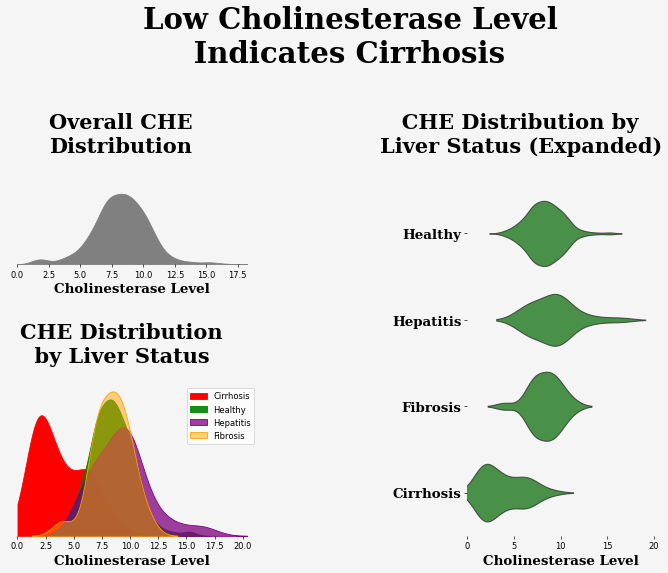

In [ ]:
#plots univariate analysis of CHE
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(data['CHE'], ax=ax1, shade=True, color='grey', alpha=1, clip=[0,400])
#Removed 'CHE' from first position and changed to data['CHE'] to explicitly use the column.
ax1.set_xlabel('Cholinesterase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='CHE', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,400])
sns.kdeplot(x='CHE', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,400])
sns.kdeplot(x='CHE', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,400])
sns.kdeplot(x='CHE', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,400])
ax2.legend()
ax2.set_xlabel('Cholinesterase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
#Removed the aspect argument. If you want to control the aspect ratio, adjust figsize or use ax.set_aspect()
ax3_plot = sns.violinplot(x='CHE', y='Category', data=data,  ax=ax3, inner=None)
ax3.set_xlim(0,20)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Cholinesterase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall CHE\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "CHE Distribution\n  by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "   CHE Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})

fig.text(0.145, 0.9, "Low Cholinesterase Level\n     Indicates Cirrhosis",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

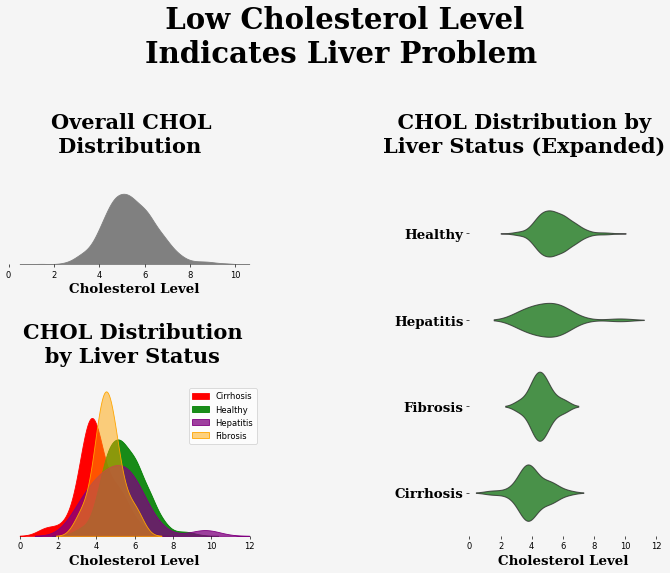

In [ ]:
#plots univariate analysis of CHOL
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='CHOL', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,400])
ax1.set_xlabel('Cholesterol Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

sns.kdeplot(x='CHOL', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,400])
sns.kdeplot(x='CHOL', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,400])
sns.kdeplot(x='CHOL', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,400])
sns.kdeplot(x='CHOL', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,400])

ax2.legend()
ax2.set_xlabel('Cholesterol Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='CHOL', y='Category', data=data,  ax=ax3, inner=None) #Removed aspect=2
ax3.set_xlim(0,12)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Cholesterol Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall CHOL\n Distribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "CHOL Distribution\n   by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "  CHOL Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})


fig.text(0.145, 0.9, "  Low Cholesterol Level\nIndicates Liver Problem",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

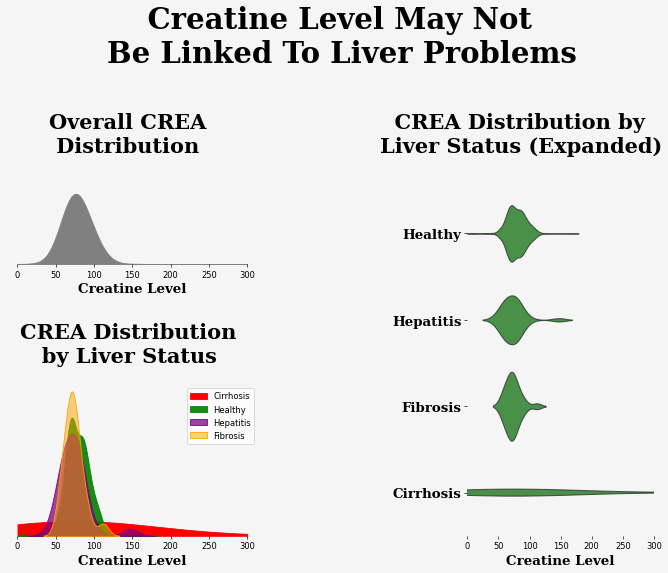

In [ ]:
#plots univariate analysis of CREA
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='CREA', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,300])
ax1.set_xlabel('Creatine Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='CREA', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,300])
sns.kdeplot(x='CREA', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,300])
sns.kdeplot(x='CREA', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,300])
sns.kdeplot(x='CREA', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,300])

ax2.legend()
ax2.set_xlabel('Creatine Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
# Removed the 'aspect' argument from sns.violinplot
ax3_plot = sns.violinplot(x='CREA', y='Category', data=data,  ax=ax3, inner=None)
ax3.set_xlim(0,300)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Creatine Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall CREA\n Distribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "CREA Distribution\n   by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "  CREA Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})


fig.text(0.12, 0.9, "    Creatine Level May Not\nBe Linked To Liver Problems",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

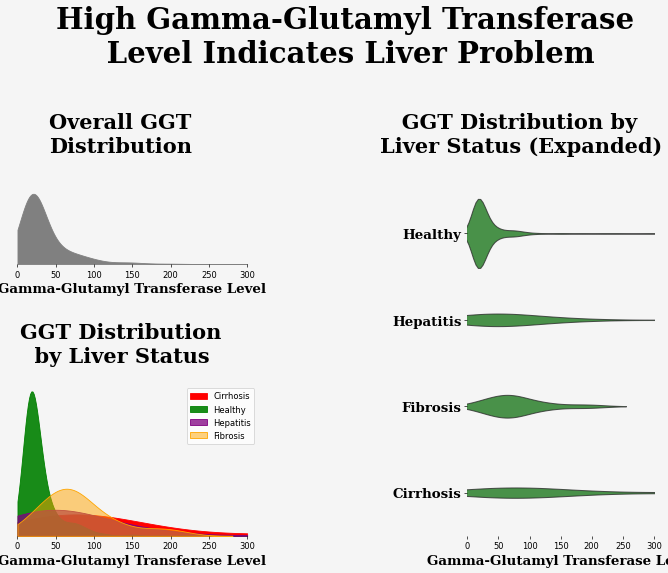

In [ ]:
#plots univariate analysis of GGT
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='GGT', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,300])
ax1.set_xlabel('Gamma-Glutamyl Transferase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='GGT', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,300])
sns.kdeplot(x='GGT', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,300])
sns.kdeplot(x='GGT', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,300])
sns.kdeplot(x='GGT', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,300])

ax2.legend()
ax2.set_xlabel('Gamma-Glutamyl Transferase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
ax3_plot = sns.violinplot(x='GGT', y='Category', data=data,  ax=ax3, inner=None)
#Removed aspect=2. If you want to control the aspect ratio, adjust figsize or use ax.set_aspect()
ax3.set_xlim(0,300)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Gamma-Glutamyl Transferase Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall GGT\nDistribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "GGT Distribution\n  by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "   GGT Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})


fig.text(0.085, 0.9, "High Gamma-Glutamyl Transferase\n     Level Indicates Liver Problem",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})#title

plt.show()

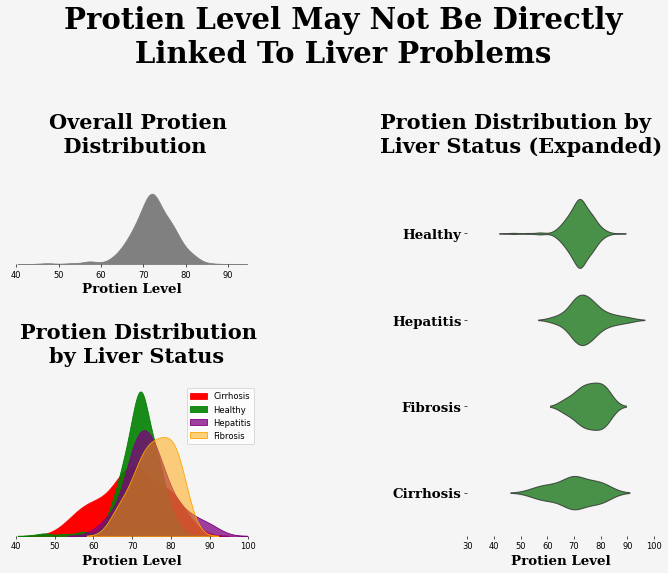

In [ ]:
#plots univariate analysis of PROT
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=10, nrows=12, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[3:5, 0:4])
ax2 = fig.add_subplot(gs[8:, 0:4])
ax3 = fig.add_subplot(gs[3:, 7:])

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)



#-------Ax 1------------------------------------------------
sns.kdeplot(x='PROT', data=data, ax=ax1, shade=True, color='grey', alpha=1, clip=[0,300])
ax1.set_xlabel('Protien Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

#-------Ax 2------------------------------------------------
sns.kdeplot(x='PROT', data=data[data.Category=='Cirrhosis'], ax=ax2, shade=True, color='red',
            alpha=1, label='Cirrhosis', clip=[0,300])
sns.kdeplot(x='PROT', data=data[data.Category=='Healthy'], ax=ax2, shade=True, color='green',
            alpha=0.9, label='Healthy', clip=[0,300])
sns.kdeplot(x='PROT', data=data[data.Category=='Hepatitis'], ax=ax2, shade=True, color='purple',
            alpha=0.75, label='Hepatitis', clip=[0,300])
sns.kdeplot(x='PROT', data=data[data.Category=='Fibrosis'], ax=ax2, shade=True, color='orange',
            alpha=0.5, label='Fibrosis', clip=[0,300])

ax2.legend()
ax2.set_xlabel('Protien Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})


#-------Ax 3------------------------------------------------
# Removed the 'aspect' argument. If you want to control the aspect ratio, adjust figsize or use ax.set_aspect()
ax3_plot = sns.violinplot(x='PROT', y='Category', data=data,  ax=ax3, inner=None)
ax3.set_xlim(30,100)
for item in ax3_plot.collections[::]:
    item.set_alpha(0.75)
ax3.axes.get_yaxis().set_visible(True)
ax3.set_ylabel('')
ax3.set_yticklabels( labels = ['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
ax3.set_xlabel('Protien Level', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
#--------------------------------------------------------
#axes titles
#ax1
fig.text(0.08, 0.75, "Overall Protien\n  Distribution",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax2
fig.text(0.06, 0.4, "Protien Distribution\n    by Liver Status",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})
#ax3
fig.text(0.31, 0.75, "Protien Distribution by\nLiver Status (Expanded)",
        {'font':'Serif', 'fontsize':25,'fontweight':'bold', 'color':'black'})


#fig title
fig.text(0.09, 0.9, "Protien Level May Not Be Directly\n       Linked To Liver Problems",
        {'font':'Serif', 'fontsize':35,'fontweight':'bold', 'color':'black'})


plt.show()

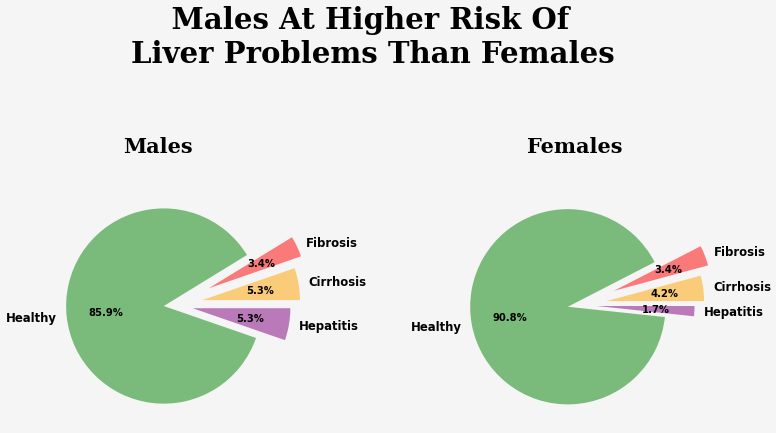

In [ ]:
#plots univariate analysis of Sex
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])


# axes list
axes = [ ax1,ax2]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------
#ax1
ax1_plot = ax1.pie(data[data.Sex == 'm'].groupby('Category').Category.count().values,
                   labels=data.groupby('Category').Category.count().index,
                    autopct='%1.1f%%', explode=[0.3,  0.4, 0.1, 0.2],
                   colors=['orange', 'red', 'green', 'purple'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax1_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax1_plot[2]):
    text.set_weight('bold')
    text.set_size(12)


fig.text(0.1, 0.75, 'Males',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#------------------------------------------------------------
#ax2
ax2_plot = ax2.pie(data[data.Sex == 'f'].groupby('Category').Category.count().values,
                   labels=data.groupby('Category').Category.count().index,
                    autopct='%1.1f%%', explode=[0.3,  0.4, 0.1, 0.2],
                   colors=['orange', 'red', 'green', 'purple'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax2_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax2_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.38, 0.75, 'Females',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#--------------------------------
fig.text(0.105, 0.9, '    Males At Higher Risk Of\nLiver Problems Than Females',
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
plt.show()

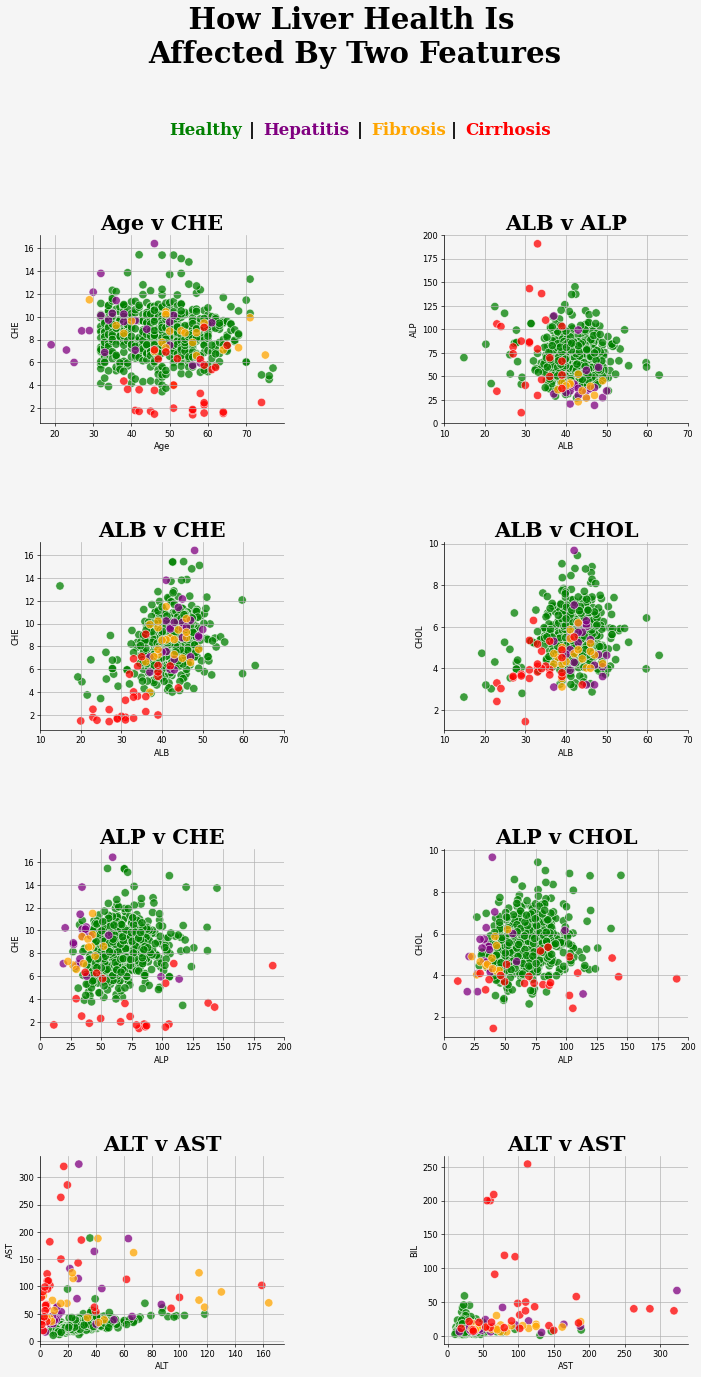

In [ ]:
#plots bivariate data
fig = plt.figure(figsize = (24,24), dpi = 60)
gs = GridSpec(ncols=13, nrows=29, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:5, :5])
ax2 = fig.add_subplot(gs[:5, 8:])
ax3 = fig.add_subplot(gs[8:13, :5])
ax4 = fig.add_subplot(gs[8:13, 8:])
ax5 = fig.add_subplot(gs[16:21, :5])
ax6 = fig.add_subplot(gs[16:21, 8:])
ax7 = fig.add_subplot(gs[24:, :5])
ax8 = fig.add_subplot(gs[24:, 8:])


# axes list
axes = [ ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.set_facecolor('#f5f5f5')
    ax.grid()

    for loc in ['right', 'top']:
        ax.spines[loc].set_visible(False)


#-------------------------------------------------------------------------------
#ax1 Age v CHE
sns.scatterplot(x='Age', y='CHE', hue='Category', data=data, ax=ax1, s=100, alpha=0.75, legend=None)
ax1.set_title('Age v CHE', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#-------------------------------------------------------------------------------
#ax2 ALB v ALP
sns.scatterplot(x='ALB', y='ALP', hue='Category', data=data, ax=ax2, s=100, alpha=0.75, legend=None)
ax2.set_title('ALB v ALP', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
ax2.set_xlim(10, 70)
ax2.set_ylim(0,200)
#-------------------------------------------------------------------------------
#ax3 ALB v CHE
sns.scatterplot(x='ALB', y='CHE', hue='Category', data=data, ax=ax3, s=100, alpha=0.75, legend=None)
ax3.set_title('ALB v CHE', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
ax3.set_xlim(10, 70)
#-------------------------------------------------------------------------------
#ax4 ALB v CHOL
sns.scatterplot(x='ALB', y='CHOL', hue='Category', data=data, ax=ax4, s=100, alpha=0.75, legend=None)
ax4.set_title('ALB v CHOL', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
ax4.set_xlim(10, 70)
#-------------------------------------------------------------------------------
#ax5 ALP v CHE
sns.scatterplot(x='ALP', y='CHE', hue='Category', data=data, ax=ax5, s=100, alpha=0.75, legend=None)
ax5.set_title('ALP v CHE', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
ax5.set_xlim(0, 200)
#-------------------------------------------------------------------------------
#ax6 ALP v CHOL
sns.scatterplot(x='ALP', y='CHOL', hue='Category', data=data, ax=ax6, s=100, alpha=0.75, legend=None)
ax6.set_title('ALP v CHOL', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
ax6.set_xlim(0, 200)
#-------------------------------------------------------------------------------
#ax7 ALT v AST
sns.scatterplot(x='ALT', y='AST', hue='Category', data=data, ax=ax7, s=100, alpha=0.75, legend=None)
ax7.set_title('ALT v AST', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
ax7.set_xlim(0, 175)
#-------------------------------------------------------------------------------
#ax8 AST v BIL
sns.scatterplot(x='AST', y='BIL', hue='Category', data=data, ax=ax8, s=100, alpha=0.75, legend=None)
ax8.set_title('ALT v AST', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#ax8.set_xlim(0, 175)


#-------------------------------------------
fig.text(0.1 + 0.04, 0.95, "Healthy",
         {'font':'Serif', 'weight':'bold','color': 'green', 'size':20})
fig.text(0.155 + 0.04, 0.95, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.165 + 0.04, 0.95, "Hepatitis",
         {'font':'Serif', 'weight':'bold','color': 'purple', 'size':20})
fig.text(0.23 + 0.04, 0.95, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.24 + 0.04, 0.95, "Fibrosis",
         {'font':'Serif', 'weight':'bold','color': 'orange', 'size':20})
fig.text(0.295 + 0.04, 0.95, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.305 + 0.04, 0.95, "Cirrhosis",
         {'font':'Serif', 'weight':'bold','color': 'red', 'size':20})


fig.text(0.125, 1, "    How Liver Health Is\nAffected By Two Features",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
plt.show()

In [ ]:
#creates lower dimension dataset to visualize multiple features at once
#first preprocess data
#sets Sex to 0 (m) or 1 (f)
gender_map = {'m': 0, 'f': 1}
data['Sex'] = data.Sex.map(gender_map)

#creates pipeline for data processing
ct = ColumnTransformer([
    ('scaler', StandardScaler(), [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
], remainder='passthrough')

knn_imp = KNNImputer(n_neighbors=5)

pipeline = Pipeline([
    ('scale', ct),
    ('impute', knn_imp)
])

X = pipeline.fit_transform(data.iloc[:, 1:].values)
y = data.Category.values

pca_1d = PCA(n_components=1)
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

X_1d = pca_1d.fit_transform(X).reshape(1,-1)[0]
X_2d = pca_2d.fit_transform(X).reshape(2, -1)
X_3d = pca_3d.fit_transform(X).reshape(3, -1)

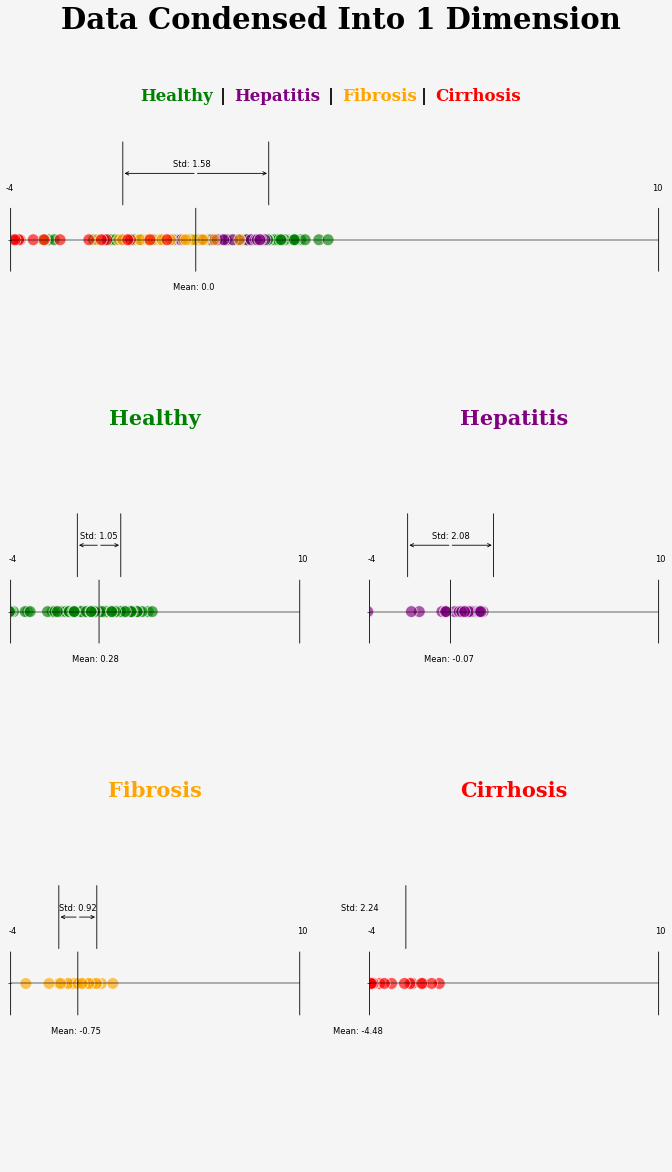

In [ ]:
#1d data
fig = plt.figure(figsize = (24,24), dpi = 60)
gs = GridSpec(ncols=11, nrows=15, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:5, :])
ax2 = fig.add_subplot(gs[5:10, :5])
ax3 = fig.add_subplot(gs[5:10, 6:])
ax4 = fig.add_subplot(gs[10:, :5])
ax5 = fig.add_subplot(gs[10:, 6:])
# axes list
axes = [ ax1,ax2,ax3,ax4, ax5]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    ax.set_yticks([0], [''])
    ax.set_xticks([])
    ax.grid(color='black', lw=2., alpha=0.35)
    ax.set_xlim(-4, 10)
    ax.annotate("", xy=(-4, -0.01), xytext=(-4, 0.01),
                xycoords='data', arrowprops=dict(arrowstyle='-'))
    ax.annotate("", xy=(10, -0.01), xytext=(10, 0.01),
                xycoords='data', arrowprops=dict(arrowstyle='-'))
    ax.text(-4.1, 0.015, '-4')
    ax.text(9.85, 0.015, '10')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)


#-----------------------------------------------------------
#ax1
sns.scatterplot(x=X_1d, y=[0 for i in y], hue=y, s=200, alpha=0.65, ax=ax1, legend=False)
all_mean = X_1d.mean()
all_std = X_1d.std()
ax1.annotate("", xy=(all_mean, -0.01), xytext=(all_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax1.text(all_mean - 0.5, -0.015, 'Mean: {}'.format(round(all_mean,2)))

ax1.annotate("", xy=(all_mean, 0.02), xytext=(all_mean-all_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax1.annotate("", xy=(all_mean-all_std, 0.01), xytext=(all_mean-all_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax1.annotate("", xy=(all_mean, 0.02), xytext=(all_mean+all_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax1.annotate("", xy=(all_mean+all_std, 0.01), xytext=(all_mean+all_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax1.text(all_mean - 0.5, 0.022, 'Std: {}'.format(round(all_std,2)))
#-----------------------------------------------------------
#ax2
healthy_ix  = [i for i in range(len(y)) if y[i] == 'Healthy']
sns.scatterplot(x=X_1d[healthy_ix], y=[0 for i in healthy_ix],  s=200,
                c=['green' for i in healthy_ix], alpha=0.65, ax=ax2, legend=False)
healthy_mean = X_1d[healthy_ix].mean()
healthy_std = X_1d[healthy_ix].std()
ax2.annotate("", xy=(healthy_mean, -0.01), xytext=(healthy_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax2.text(healthy_mean - 1.3, -0.015, 'Mean: {}'.format(round(healthy_mean,2)))

ax2.annotate("", xy=(healthy_mean, 0.02), xytext=(healthy_mean-healthy_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax2.annotate("", xy=(healthy_mean-healthy_std, 0.01), xytext=(healthy_mean-healthy_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax2.annotate("", xy=(healthy_mean, 0.02), xytext=(healthy_mean+healthy_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax2.annotate("", xy=(healthy_mean+healthy_std, 0.01), xytext=(healthy_mean+healthy_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax2.text(healthy_mean - 0.9, 0.022, 'Std: {}'.format(round(healthy_std,2)))

ax2.set_title('Healthy', {'font':'Serif', 'weight':'bold','color': 'green', 'size':25})
#-----------------------------------------------------------
#ax3
hepatitis_ix  = [i for i in range(len(y)) if y[i] == 'Hepatitis']
sns.scatterplot(x=X_1d[hepatitis_ix], y=[0 for i in hepatitis_ix],  s=200,
                c=['purple' for i in hepatitis_ix], alpha=0.65, ax=ax3, legend=False)
hepatitis_mean = X_1d[hepatitis_ix].mean()
hepatitis_std = X_1d[hepatitis_ix].std()
ax3.annotate("", xy=(hepatitis_mean, -0.01), xytext=(hepatitis_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax3.text(hepatitis_mean - 1.3, -0.015, 'Mean: {}'.format(round(hepatitis_mean,2)))

ax3.annotate("", xy=(hepatitis_mean, 0.02), xytext=(hepatitis_mean-hepatitis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax3.annotate("", xy=(hepatitis_mean-hepatitis_std, 0.01), xytext=(hepatitis_mean-hepatitis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax3.annotate("", xy=(hepatitis_mean, 0.02), xytext=(hepatitis_mean+hepatitis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax3.annotate("", xy=(hepatitis_mean+hepatitis_std, 0.01), xytext=(hepatitis_mean+hepatitis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax3.text(hepatitis_mean - 0.9, 0.022, 'Std: {}'.format(round(hepatitis_std,2)))

ax3.set_title('Hepatitis', {'font':'Serif', 'weight':'bold','color': 'purple', 'size':25})
#-----------------------------------------------------------
#ax4
fibrosis_ix  = [i for i in range(len(y)) if y[i] == 'Fibrosis']
sns.scatterplot(x=X_1d[fibrosis_ix], y=[0 for i in fibrosis_ix],  s=200,
                c=['orange' for i in fibrosis_ix], alpha=0.65, ax=ax4, legend=False)
fibrosis_mean = X_1d[fibrosis_ix].mean()
fibrosis_std = X_1d[fibrosis_ix].std()
ax4.annotate("", xy=(fibrosis_mean, -0.01), xytext=(fibrosis_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax4.text(fibrosis_mean - 1.3, -0.015, 'Mean: {}'.format(round(fibrosis_mean,2)))

ax4.annotate("", xy=(fibrosis_mean, 0.02), xytext=(fibrosis_mean-fibrosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax4.annotate("", xy=(fibrosis_mean-fibrosis_std, 0.01), xytext=(fibrosis_mean-fibrosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax4.annotate("", xy=(fibrosis_mean, 0.02), xytext=(fibrosis_mean+fibrosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax4.annotate("", xy=(fibrosis_mean+fibrosis_std, 0.01), xytext=(fibrosis_mean+fibrosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax4.text(fibrosis_mean - 0.9, 0.022, 'Std: {}'.format(round(fibrosis_std,2)))

ax4.set_title('Fibrosis', {'font':'Serif', 'weight':'bold','color': 'orange', 'size':25})
#-----------------------------------------------------------
#ax5
cirrhosis_ix  = [i for i in range(len(y)) if y[i] == 'Cirrhosis']
sns.scatterplot(x=X_1d[cirrhosis_ix], y=[0 for i in cirrhosis_ix],  s=200,
                c=['red' for i in cirrhosis_ix], alpha=0.65, ax=ax5, legend=False)
cirrhosis_mean = X_1d[cirrhosis_ix].mean()
cirrhosis_std = X_1d[cirrhosis_ix].std()
ax5.annotate("", xy=(cirrhosis_mean, -0.01), xytext=(cirrhosis_mean, 0.01),
            xycoords='data', arrowprops=dict(arrowstyle='-'))
ax5.text(cirrhosis_mean - 1.3, -0.015, 'Mean: {}'.format(round(cirrhosis_mean,2)))

ax5.annotate("", xy=(cirrhosis_mean, 0.02), xytext=(cirrhosis_mean-cirrhosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax5.annotate("", xy=(cirrhosis_mean-cirrhosis_std, 0.01), xytext=(cirrhosis_mean-cirrhosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax5.annotate("", xy=(cirrhosis_mean, 0.02), xytext=(cirrhosis_mean+cirrhosis_std, 0.02),
            arrowprops=dict(arrowstyle='<-'))
ax5.annotate("", xy=(cirrhosis_mean+cirrhosis_std, 0.01), xytext=(cirrhosis_mean+cirrhosis_std, 0.03),
            arrowprops=dict(arrowstyle='-'))
ax5.text(cirrhosis_mean - 0.9, 0.022, 'Std: {}'.format(round(cirrhosis_std,2)))

ax5.set_title('Cirrhosis', {'font':'Serif', 'weight':'bold','color': 'red', 'size':25})
#-----------------------------------------------------------

fig.text(0.1 + 0.04, 0.85, "Healthy",
         {'font':'Serif', 'weight':'bold','color': 'green', 'size':20})
fig.text(0.155 + 0.04, 0.85, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.165 + 0.04, 0.85, "Hepatitis",
         {'font':'Serif', 'weight':'bold','color': 'purple', 'size':20})
fig.text(0.23 + 0.04, 0.85, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.24 + 0.04, 0.85, "Fibrosis",
         {'font':'Serif', 'weight':'bold','color': 'orange', 'size':20})
fig.text(0.295 + 0.04, 0.85, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.305 + 0.04, 0.85, "Cirrhosis",
         {'font':'Serif', 'weight':'bold','color': 'red', 'size':20})
fig.text(0.085, 0.9, 'Data Condensed Into 1 Dimension', {'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
plt.show()

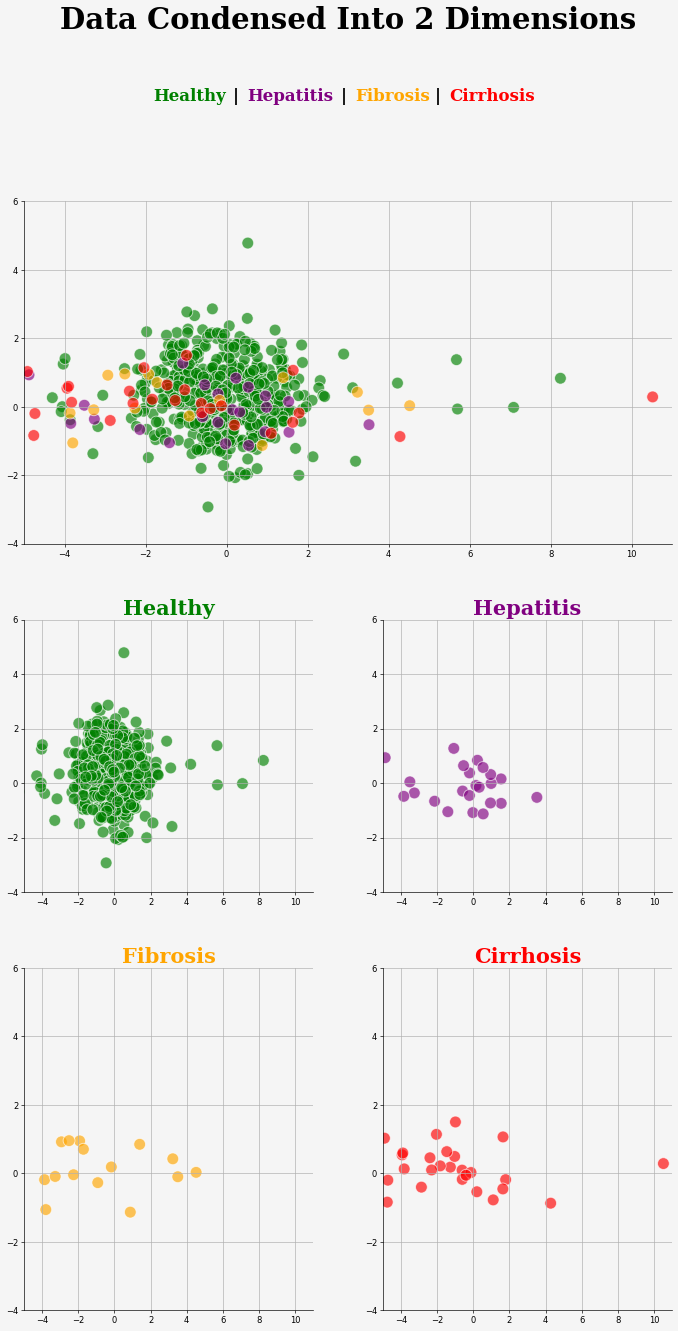

In [ ]:
#2d data
fig = plt.figure(figsize = (24,24), dpi = 60)
gs = GridSpec(ncols=11, nrows=16, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:5, :])
ax2 = fig.add_subplot(gs[6:10, :5])
ax3 = fig.add_subplot(gs[6:10, 6:])
ax4 = fig.add_subplot(gs[11:, :5])
ax5 = fig.add_subplot(gs[11:, 6:])
# axes list
axes = [ ax1,ax2,ax3,ax4, ax5]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    ax.grid()
    ax.set_xlim(-5, 11)
    ax.set_ylim(-4, 6)
    for loc in ['right', 'top']:
        ax.spines[loc].set_visible(False)


#-----------------------------------------------------------
#ax1
sns.scatterplot(x=X_2d[1], y=X_2d[0], hue=y, s=200, alpha=0.65, ax=ax1, legend=False)

#-----------------------------------------------------------
#ax2
healthy_ix  = [i for i in range(len(y)) if y[i] == 'Healthy']
sns.scatterplot(x=X_2d[1][healthy_ix], y=X_2d[0][healthy_ix], s=200,
                c=['green' for i in healthy_ix], alpha=0.65, ax=ax2, legend=False)

ax2.set_title('Healthy', {'font':'Serif', 'weight':'bold','color': 'green', 'size':25})
#-----------------------------------------------------------
#ax3
hepatitis_ix  = [i for i in range(len(y)) if y[i] == 'Hepatitis']
sns.scatterplot(x=X_2d[1][hepatitis_ix], y=X_2d[0][hepatitis_ix], s=200,
                c=['purple' for i in hepatitis_ix], alpha=0.65, ax=ax3, legend=False)


ax3.set_title('Hepatitis', {'font':'Serif', 'weight':'bold','color': 'purple', 'size':25})
#-----------------------------------------------------------
#ax4
fibrosis_ix  = [i for i in range(len(y)) if y[i] == 'Fibrosis']
sns.scatterplot(x=X_2d[1][fibrosis_ix], y=X_2d[0][fibrosis_ix], s=200,
                c=['orange' for i in fibrosis_ix], alpha=0.65, ax=ax4, legend=False)


ax4.set_title('Fibrosis', {'font':'Serif', 'weight':'bold','color': 'orange', 'size':25})
#-----------------------------------------------------------
#ax5
cirrhosis_ix  = [i for i in range(len(y)) if y[i] == 'Cirrhosis']
sns.scatterplot(x=X_2d[1][cirrhosis_ix], y=X_2d[0][cirrhosis_ix], s=200,
                c=['red' for i in cirrhosis_ix], alpha=0.65, ax=ax5, legend=False)

ax5.set_title('Cirrhosis', {'font':'Serif', 'weight':'bold','color': 'red', 'size':25})
#-----------------------------------------------------------

fig.text(0.1 + 0.04, 0.95, "Healthy",
         {'font':'Serif', 'weight':'bold','color': 'green', 'size':20})
fig.text(0.155 + 0.04, 0.95, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.165 + 0.04, 0.95, "Hepatitis",
         {'font':'Serif', 'weight':'bold','color': 'purple', 'size':20})
fig.text(0.23 + 0.04, 0.95, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.24 + 0.04, 0.95, "Fibrosis",
         {'font':'Serif', 'weight':'bold','color': 'orange', 'size':20})
fig.text(0.295 + 0.04, 0.95, "|",
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':20})
fig.text(0.305 + 0.04, 0.95, "Cirrhosis",
         {'font':'Serif', 'weight':'bold','color': 'red', 'size':20})
fig.text(0.075, 1, 'Data Condensed Into 2 Dimensions', {'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
plt.show()

In [ ]:
#converts y to float values
y_float = np.where(y=='Healthy', 0.0, y)
y_float = np.where(y_float=='Hepatitis', 1.0, y_float)
y_float = np.where(y_float=='Fibrosis', 2.0, y_float)
y_float = np.where(y_float=='Cirrhosis', 3.0, y_float).astype('float64')
#splits data into train, validation, and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_float, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=8)
#SMOTE for class balancing
sm = SMOTE(random_state=8)

#create new training set with SMOTE object
X_bal, y_bal = sm.fit_resample(X_train, y_train)

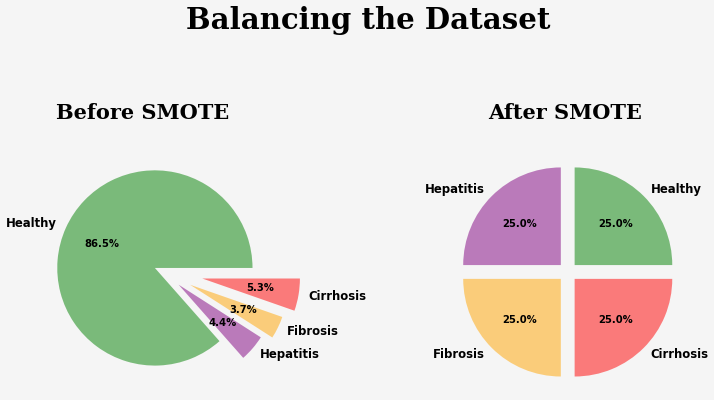

In [ ]:
#plots target data
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])


# axes list
axes = [ ax1,ax2]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')

    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------
#ax1
pre_smote_count = [len(y_train[y_train==0.0]), len(y_train[y_train==1.0]),
                  len(y_train[y_train==2.0]), len(y_train[y_train==3.0])]
ax1_plot = ax1.pie(pre_smote_count,
                   labels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                    autopct='%1.1f%%', explode=[0.1,  0.2, 0.3, 0.4],
                   colors=['green', 'purple', 'orange', 'red'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax1_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax1_plot[2]):
    text.set_weight('bold')
    text.set_size(12)


fig.text(0.06, 0.75, 'Before SMOTE',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#------------------------------------------------------------
#ax2
post_smote_count = [len(y_bal[y_bal==0.0]), len(y_bal[y_bal==1.0]),
                  len(y_bal[y_bal==2.0]), len(y_bal[y_bal==3.0])]
ax2_plot = ax2.pie(post_smote_count,
                   labels=['Healthy', 'Hepatitis', 'Fibrosis', 'Cirrhosis'],
                    autopct='%1.1f%%', explode=[0.1,  0.1, 0.1, 0.1],
                   colors=['green', 'purple', 'orange', 'red'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax2_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax2_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.36, 0.75, 'After SMOTE',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#--------------------------------
fig.text(0.15, 0.9, 'Balancing the Dataset',
         {'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
plt.show()

In [ ]:
# OPTUNA objective function
def objective(trial):
    #------------------------------
    #logistic regression
    lr_penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2', 'elasticnet'])
    lr_l1_ratio = None
    if lr_penalty == 'l1':
        lr_solver = trial.suggest_categorical('lr_solver1', ['liblinear', 'saga'])
    elif lr_penalty == 'l2':
        lr_solver = trial.suggest_categorical('lr_solver2', ['newton-cg', 'lbfgs', 'sag', 'liblinear', 'saga'])
    else:
        lr_solver = 'saga'
        lr_l1_ratio = trial.suggest_uniform('lr_l1_ratio', 0.0, 1.0)

    lr_tol = trial.suggest_uniform('lr_tol', 1e-5, 1e-2)
    lr_C = trial.suggest_uniform('lr_C', 0.0, 1.0)

    lr = LogisticRegression(
        penalty=lr_penalty,
        tol=lr_tol,
        C=lr_C,
        solver=lr_solver,
        l1_ratio=lr_l1_ratio
    )


    #----------------------------------------------------------
    #KNN
    knn_neighbors = trial.suggest_int('knn_neighbors', 2, 100)
    knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
    knn_p = trial.suggest_categorical('knn_p', [1, 2])

    knn = KNeighborsClassifier(
        n_neighbors=knn_neighbors,
        weights=knn_weights,
        p=knn_p
    )


    #----------------------------------------------------------
    #SVM
    svm_C = trial.suggest_uniform('svm_C', 0.0, 1.0)
    svm_kernel = trial.suggest_categorical('svm_kernel', ['poly', 'rbf'])
    svm_degree = 3
    if svm_kernel == 'poly':
        svm_degree = trial.suggest_int('svm_degree', 1, 10)
    svm_tol = trial.suggest_uniform('svm_tol', 1e-5, 1e-2)

    svm = SVC(
        C=svm_C,
        kernel=svm_kernel,
        degree=svm_degree,
        tol=svm_tol
    )

    #-----------------------------------------------------------
    #random forest
    rf_estimators = trial.suggest_int('rf_estimators', 1, 500)
    rf_criterion = trial.suggest_categorical('rf_criterion', ['entropy', 'gini'])
    rf_max_depth = trial.suggest_int('rf_max_depth', 1, 100)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 50)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 25)

    rf = RandomForestClassifier(
        n_estimators=rf_estimators,
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf
    )


    #---------------------------------------------------------
    #naive bayes
    nb_smoothing = trial.suggest_uniform('nb_smoothing', 1e-10, 1e-6)
    nb = GaussianNB(var_smoothing=nb_smoothing)


    #---------------------------------------------------------

    #ensemble model
    lr_w = trial.suggest_uniform('lr_w', 0.0, 1.0)
    knn_w = trial.suggest_uniform('knn_w', 0.0, 1.0)
    svm_w = trial.suggest_uniform('svm_w', 0.0, 1.0)
    rf_w = trial.suggest_uniform('rf_w', 0.0, 1.0)
    nb_w = trial.suggest_uniform('nb_w', 0.0, 1.0)


    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb)],
                          weights=[lr_w, knn_w, svm_w, rf_w, nb_w]
                         )

    vc.fit(X_bal, y_bal)
    preds = vc.predict(X_val)

    acc = metrics.accuracy_score(y_val, preds)

    return acc

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

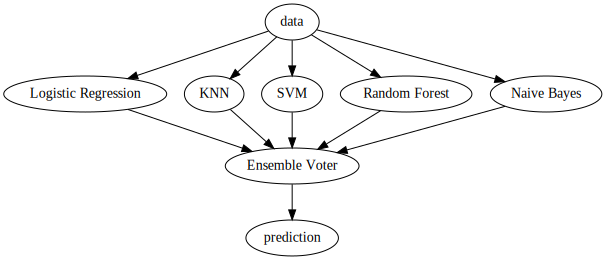

In [ ]:
ensemble_graph = graphviz.Digraph()
#first layer
ensemble_graph.edge('data', 'Logistic Regression')
ensemble_graph.edge('data', 'KNN')
ensemble_graph.edge('data', 'SVM')
ensemble_graph.edge('data', 'Random Forest')
ensemble_graph.edge('data', 'Naive Bayes')
#second layer
ensemble_graph.edge('Logistic Regression', 'Ensemble Voter')
ensemble_graph.edge('KNN', 'Ensemble Voter')
ensemble_graph.edge('SVM', 'Ensemble Voter')
ensemble_graph.edge('Random Forest', 'Ensemble Voter')
ensemble_graph.edge('Naive Bayes', 'Ensemble Voter')
#third layer
ensemble_graph.edge('Ensemble Voter', 'prediction')

ensemble_graph

In [ ]:
print('===========================================================')
print('Model Accuracy on Valadation Set:', round(study.best_trial.values[0], 2))
print('===========================================================')
print('Best Hyperparameters:')
print('===========================================================')
print(study.best_params)

Model Accuracy on Valadation Set: 0.97
Best Hyperparameters:
{'lr_penalty': 'l1', 'lr_solver1': 'liblinear', 'lr_tol': 0.005483822297101271, 'lr_C': 0.9035836988429874, 'knn_neighbors': 2, 'knn_weights': 'distance', 'knn_p': 1, 'svm_C': 0.5802858597232299, 'svm_kernel': 'poly', 'svm_degree': 6, 'svm_tol': 0.0072661886157716765, 'rf_estimators': 147, 'rf_criterion': 'entropy', 'rf_max_depth': 58, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 8, 'nb_smoothing': 6.553704672706226e-07, 'lr_w': 0.21298745114010809, 'knn_w': 0.5175555023590104, 'svm_w': 0.8034615502403242, 'rf_w': 0.9617259979013625, 'nb_w': 0.42402974671969806}


In [ ]:
#recreates a model from the best hyperparameters:
def create_model(best_params):
        #------------------------------
    try:
        l1_ratio = best_params['lr_l1_ratio']
    except:
        l1_ratio = None
    try:
        solver = best_params['lr_solver1']
    except:
        try:
            solver = best_params['lr_solver2']
        except:
            solver = 'saga'

    lr = LogisticRegression(
        penalty=best_params['lr_penalty'],
        tol=best_params['lr_tol'],
        C=best_params['lr_C'],
        l1_ratio=l1_ratio,
        solver=solver
    )


    #----------------------------------------------------------
    #KNN

    knn = KNeighborsClassifier(
        n_neighbors=best_params['knn_neighbors'],
        weights=best_params['knn_weights'],
        p=best_params['knn_p']
    )


    #----------------------------------------------------------
    #SVM
    try:
        svm_degree = best_params['svm_degree']
    except:
        svm_degree=3

    svm = SVC(
        C=best_params['svm_C'],
        kernel=best_params['svm_kernel'],
        degree=svm_degree,
        tol=best_params['svm_tol']
    )

    #-----------------------------------------------------------
    #random forest
    rf = RandomForestClassifier(
        n_estimators=best_params['rf_estimators'],
        criterion=best_params['rf_criterion'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf']
    )


    #---------------------------------------------------------
    #naive bayes
    nb = GaussianNB(var_smoothing=best_params['nb_smoothing'])


    #---------------------------------------------------------

    #ensemble model
    vc = VotingClassifier(estimators=[
        ('lr', lr),
        ('knn', knn),
        ('svm', svm),
        ('rf', rf),
        ('nb', nb)],
                          weights=[
                              best_params['lr_w'],
                              best_params['knn_w'],
                              best_params['svm_w'],
                              best_params['rf_w'],
                              best_params['nb_w']]
                         )

    vc.fit(X_bal, y_bal)

    return vc

In [ ]:
#ensemble model with best hyperparameters
model = create_model(study.best_params)

In [ ]:
#creates shap explainer
feature_names = list(data.columns)[1:2] + list(data.columns)[3:] + [list(data.columns)[2]]
explainer = shap.Explainer(model.predict, X_train, feature_names=feature_names)
shap_values = explainer(X_test)

PermutationExplainer explainer: 94it [05:16,  3.44s/it]


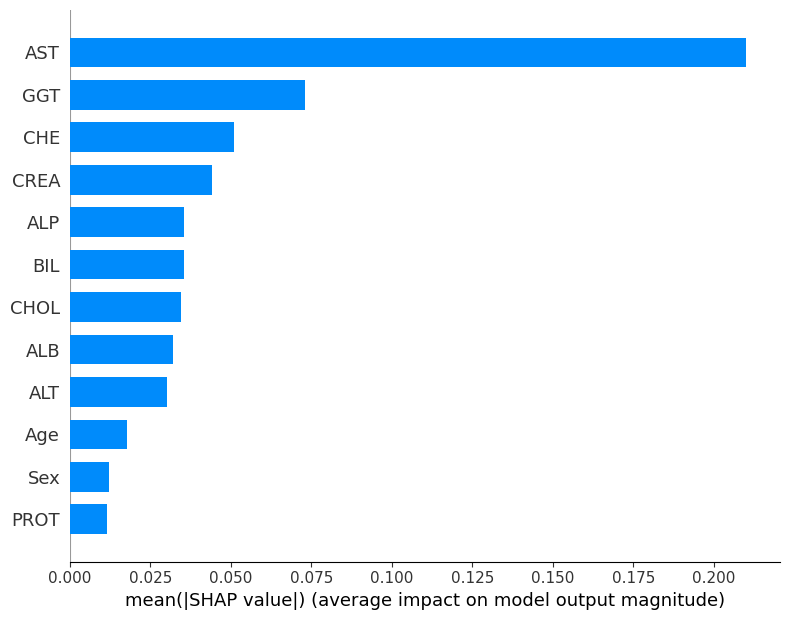

In [ ]:
#plots importance of each feature
shap.summary_plot(shap_values, X_test, plot_type="bar")

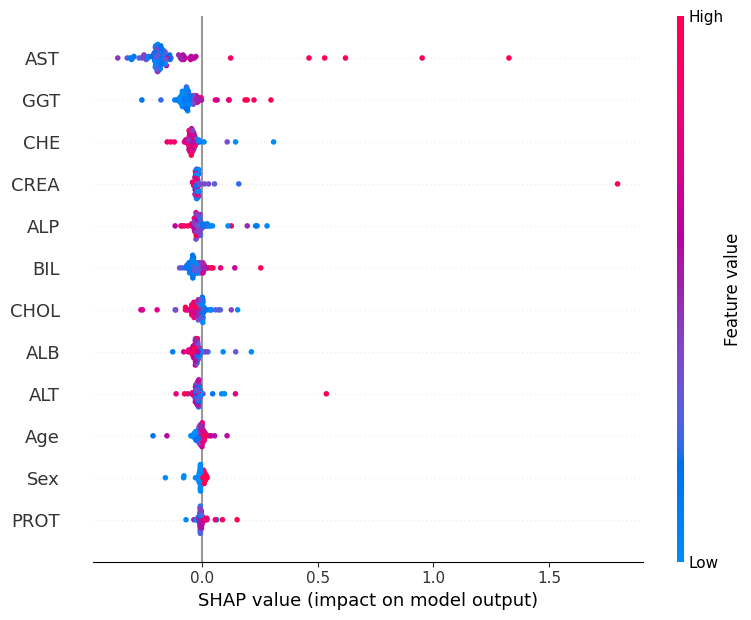

In [ ]:
#plots importance of each feature
shap.summary_plot(shap_values, X_test)

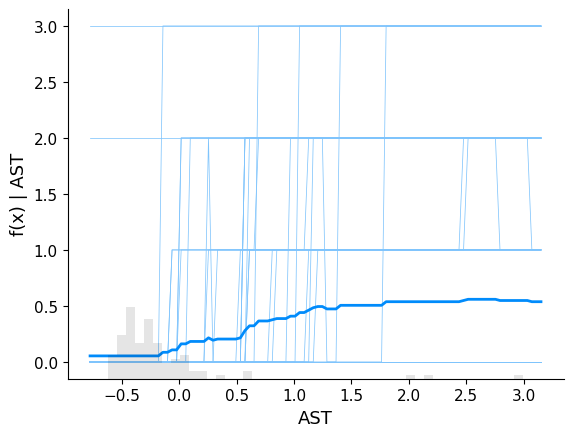

In [ ]:
#plots effect of the AST feature
shap.partial_dependence_plot(4, model.predict, X_test, feature_names=feature_names)

In [ ]:
#displays the final evaluation
test_preds = model.predict(X_test)
print('Test Accuracy:', round(metrics.accuracy_score(y_test, test_preds), 2))

Test Accuracy: 0.96
